In [23]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [24]:
(x_train,y_train),(x_test,y_test)=keras.datasets.mnist.load_data()

In [25]:
len(x_train)

60000

In [26]:
len(x_test)

10000

In [27]:
x_train[0].shape

(28, 28)

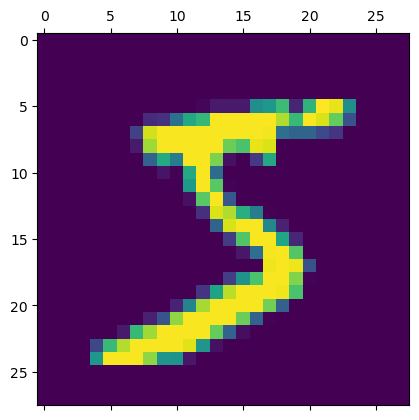

In [28]:
plt.matshow(x_train[0])

In [29]:
y_train[0]

5

In [30]:
x_train=x_train/255
x_test=x_test/255

In [31]:
model=keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(10,activation='sigmoid')
])
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(x_train,y_train,epochs=5)



Epoch 1/5


1875/1875 [==============================] - 5s 2ms/step - loss: 0.2709 - accuracy: 0.9233
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1223 - accuracy: 0.9639
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0836 - accuracy: 0.9753
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0633 - accuracy: 0.9809
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0495 - accuracy: 0.9852


In [15]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.0754 - accuracy: 0.9763


[0.07543085515499115, 0.9763000011444092]

In [16]:
model.save("./save_model")

INFO:tensorflow:Assets written to: ./save_model\assets


INFO:tensorflow:Assets written to: ./save_model\assets


## 1.) Post Training Quantization


In [14]:
convertor=tf.lite.TFLiteConverter.from_saved_model("./save_model")
tflite_model=convertor.convert()

In [15]:
len(tflite_model)

320004

In [10]:
converter=tf.lite.TFLiteConverter.from_saved_model("./save_model")


In [11]:
converter.optimizations=[tf.lite.Optimize.DEFAULT]
flite_model=converter.convert()

In [12]:
len(flite_model)

84880

In [18]:
with open("tflite_model.tflite","wb") as f:
    f.write(tflite_model)

In [19]:
with open("tflite_quant_model.tflite","wb") as f:
    f.write(flite_model)

# 2.) Quantization aware training

In [21]:
!pip install tensorflow_model_optimization

  Obtaining dependency information for tensorflow_model_optimization from https://files.pythonhosted.org/packages/cf/8b/a63b45b3f53947bda130f5feb28e88d20b6b0306ed02150399e43356b057/tensorflow_model_optimization-0.7.5-py2.py3-none-any.whl.metadata
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
     ---------------------------------------- 0.0/101.3 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/101.3 kB ? eta -:--:--
     -------------- ---------------------- 41.0/101.3 kB 393.8 kB/s eta 0:00:01
     ------------------------------------ 101.3/101.3 kB 728.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/241.2 kB ? eta -:--:--
   ----- ---------------------------------- 30.7/241.2 kB 1.3 MB/s eta 0:00:01
   --------------- ------------------------ 92.2/241.2 kB 1.3 MB/s eta 0:00:01
   ------------------ --------------------- 112.6/241.2 kB 1.3 MB/s eta 0:00:01
   ------------------- ------------------ 122.9/241.2 kB 654.9 kB/s eta 0:00:01
  

In [37]:
import tensorflow_model_optimization as tfmot
quantize_model=tfmot.quantization.keras.quantize_model
q_aware_model=quantize_model(model)

In [39]:
q_aware_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_2 (Quantize  (None, 28, 28)            3         
 Layer)                                                          
                                                                 
 quant_flatten (QuantizeWra  (None, 784)               1         
 pperV2)                                                         
                                                                 
 quant_dense (QuantizeWrapp  (None, 100)               78505     
 erV2)                                                           
                                                                 
 quant_dense_1 (QuantizeWra  (None, 10)                1015      
 pperV2)                                                         
                                                                 
Total params: 79524 (310.64 KB)
Trainable params: 79510 

In [40]:
q_aware_model.fit(x_train,y_train,epochs=1)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0424 - accuracy: 0.9864


In [41]:
q_aware_model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0722 - accuracy: 0.9766


[0.07222159951925278, 0.9765999913215637]

In [43]:
converter=tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_qaware_model=converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ccaas\AppData\Local\Temp\tmph308casw\assets


INFO:tensorflow:Assets written to: C:\Users\ccaas\AppData\Local\Temp\tmph308casw\assets
C:\Users\ccaas\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [44]:
with open("tflite_qaware_model.tflite","wb") as f:
    f.write(tflite_qaware_model)